In [0]:
import os
from dotenv import load_dotenv
import platform
import warnings
from tqdm.auto import tqdm
import numpy as np
import pickle
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import transbigdata as tbd
import datetime
import random
# import dask
# import dask.dataframe as dd
# from dask.diagnostics import ProgressBar
import math
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
# warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# sns.set_context('notebook')
# sns.set_theme(style="ticks", palette="pastel")
# plt.style.use(['grid'])

# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()
tbd.set_mapboxtoken(os.getenv('MAPBOX_TOKEN'))

# 设置字体
if platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
else:
    plt.rcParams['font.family'] = ['Arial Unicode MS']

# GPS数据
data = pd.read_csv('C:\\Users\\y\\Desktop\\新建文件夹 (2)\\交通赛数据_上\\20140803_train.txt', 
                   header=None,
                   names=['出租车ID', '纬度', '经度', '载客状态', '时间点'])
data['纬度'] = data['纬度'].astype(float)
data['经度'] = data['经度'].astype(float)
data['时间点'] = pd.to_datetime(data['时间点'])
data['小时'] = data['时间点'].dt.hour
data['时间段'] = pd.cut(data['小时'], bins=[0, 6, 12, 18, 24], labels=['凌晨', '上午', '下午', '晚上'])
data

Set mapboxtoken success


,出租车ID,纬度,经度,载客状态,时间点,小时,时间段
0,1,30.624806,104.136604,1,2014-08-03 21:18:46,21,晚上
1,1,30.624809,104.136612,1,2014-08-03 21:18:15,21,晚上
2,1,30.624811,104.136587,1,2014-08-03 21:20:17,21,晚上
3,1,30.624811,104.136596,1,2014-08-03 21:19:16,21,晚上
4,1,30.624811,104.136619,1,2014-08-03 21:17:44,21,晚上
...,...,...,...,...,...,...,...
53045402,13605,30.732042,103.998304,1,2014-08-03 11:24:41,11,上午
53045403,13605,30.732262,103.997677,1,2014-08-03 11:28:58,11,上午
53045404,13605,30.732322,103.997589,1,2014-08-03 11:25:21,11,上午
53045405,13605,30.732406,103.997811,1,2014-08-03 11:25:12,11,上午


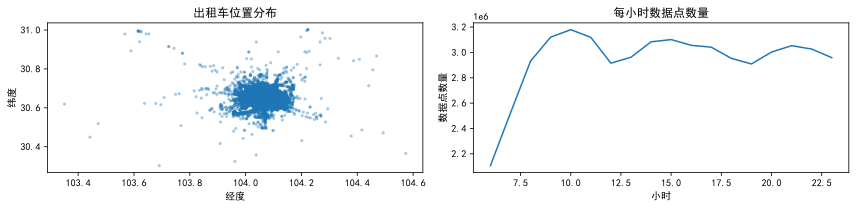

In [1]:
dd = data.sample(10000)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# 出租车位置分布图
ax1.scatter(dd['经度'], dd['纬度'], alpha=0.3, s=5)
ax1.set_title('出租车位置分布')
ax1.set_xlabel('经度')
ax1.set_ylabel('纬度')

# 每小时数据点数量图
hourly_counts = data.groupby('小时').size()
hourly_counts.plot(kind='line', ax=ax2)
ax2.set_title('每小时数据点数量')
ax2.set_xlabel('小时')
ax2.set_ylabel('数据点数量')

plt.tight_layout()
plt.show()

In [12]:
# 定义栅格化函数
def create_grid(data, lat_bins=100, lon_bins=100):
    lat_min, lat_max = data['纬度'].min(), data['纬度'].max()
    lon_min, lon_max = data['经度'].min(), data['经度'].max()
    
    lat_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
    lon_edges = np.linspace(lon_min, lon_max, lon_bins + 1)
    
    data['lat_bin'] = pd.cut(data['纬度'], bins=lat_edges, labels=False, include_lowest=True)
    data['lon_bin'] = pd.cut(data['经度'], bins=lon_edges, labels=False, include_lowest=True)
    
    return data, lat_edges, lon_edges

# 栅格化数据
data, lat_edges, lon_edges = create_grid(data)

In [13]:
data

,出租车ID,纬度,经度,载客状态,时间点,小时,时间段,lat_bin,lon_bin,POI,POI_poi,POI_poi,POI_poi,POI_poi,POI_poi
0,1,30.624806,104.136604,1,2014-08-03 21:18:46,21,晚上,45,64,NaN,NaN,NaN,NaN,NaN,NaN
1,1,30.624809,104.136612,1,2014-08-03 21:18:15,21,晚上,45,64,NaN,NaN,NaN,NaN,NaN,NaN
2,1,30.624811,104.136587,1,2014-08-03 21:20:17,21,晚上,45,64,NaN,NaN,NaN,NaN,NaN,NaN
3,1,30.624811,104.136596,1,2014-08-03 21:19:16,21,晚上,45,64,NaN,NaN,NaN,NaN,NaN,NaN
4,1,30.624811,104.136619,1,2014-08-03 21:17:44,21,晚上,45,64,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53045402,13605,30.732042,103.998304,1,2014-08-03 11:24:41,11,上午,59,54,NaN,NaN,NaN,NaN,NaN,NaN
53045403,13605,30.732262,103.997677,1,2014-08-03 11:28:58,11,上午,59,54,NaN,NaN,NaN,NaN,NaN,NaN
53045404,13605,30.732322,103.997589,1,2014-08-03 11:25:21,11,上午,59,54,NaN,NaN,NaN,NaN,NaN,NaN
53045405,13605,30.732406,103.997811,1,2014-08-03 11:25:12,11,上午,59,54,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
import os
from dotenv import load_dotenv
load_dotenv()

# 定义栅格化函数
def create_grid(data, lat_bins=100, lon_bins=100):
    lat_min, lat_max = data['纬度'].min(), data['纬度'].max()
    lon_min, lon_max = data['经度'].min(), data['经度'].max()
    
    lat_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
    lon_edges = np.linspace(lon_min, lon_max, lon_bins + 1)
    
    data['lat_bin'] = pd.cut(data['纬度'], bins=lat_edges, labels=False, include_lowest=True)
    data['lon_bin'] = pd.cut(data['经度'], bins=lon_edges, labels=False, include_lowest=True)
    
    return data, lat_edges, lon_edges

# 栅格化数据
data, lat_edges, lon_edges = create_grid(data)

# 统计每个网格的数据点数量
grid_counts = data.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='count')

# 选择前13个最多出租车数量的栅格
top_13_grids = grid_counts.nlargest(13, 'count')

# 为这13个栅格分配POI编号
top_13_grids['POI'] = range(1, 14)

# 将POI信息合并回原始数据，使用suffixes参数避免重复列名
data = data.merge(top_13_grids[['lat_bin', 'lon_bin', 'POI']], on=['lat_bin', 'lon_bin'], how='left', suffixes=('', '_poi'))

In [10]:
# 使用Mapbox绘制底图并可视化13个POI
import plotly.express as px

# 设置Mapbox访问令牌
px.set_mapbox_access_token(os.getenv('MAPBOX_TOKEN'))

# 计算经纬度范围
lon_range = [data['经度'].min(), data['经度'].max()]
lat_range = [data['纬度'].min(), data['纬度'].max()]

# 创建散点图
fig = px.scatter_mapbox(top_13_grids, 
                        lat=lat_edges[top_13_grids['lat_bin']],
                        lon=lon_edges[top_13_grids['lon_bin']],
                        size='count', 
                        color='POI',
                        hover_name='POI',
                        zoom=10,
                        height=800,
                        width=1000)

# 更新布局
fig.update_layout(
    title='13个最热门POI位置',
    mapbox=dict(
        style="streets",  # 将 "light" 改为 "streets"
        center=dict(lon=np.mean(lon_range), lat=np.mean(lat_range)),
        zoom=10
    )
)

# 显示图表
fig.show()

In [22]:
top_13_grids

,lat_bin,lon_bin,count,POI
1987,49,59,918484,1
1933,48,59,889976,2
1934,48,60,745274,3
1988,49,60,732036,4
1880,47,60,622832,5
2238,54,59,585937,6
2088,51,58,585826,7
1881,47,61,584909,8
1331,37,51,550680,9
1878,47,58,549073,10


In [14]:
# 删除POI为NaN的行
data_with_poi = data.dropna(subset=['POI'])

# 按出租车ID和时间点排序
data_with_poi = data_with_poi.sort_values(['出租车ID', '时间点'])

# 创建一个新的DataFrame来存储结果
result = []

# 遍历每个出租车ID
for taxi_id, group in data_with_poi.groupby('出租车ID'):
    # 找到连续的POI变化
    poi_changes = group[group['POI'] != group['POI'].shift()]
    
    # 如果有至少两个POI点，则计算行程
    if len(poi_changes) >= 2:
        for i in range(len(poi_changes) - 1):
            start_poi = poi_changes.iloc[i]['POI']
            end_poi = poi_changes.iloc[i+1]['POI']
            start_time = poi_changes.iloc[i]['时间点']
            end_time = poi_changes.iloc[i+1]['时间点']
            duration = (end_time - start_time).total_seconds() / 60  # 转换为分钟
            
            result.append({
                '出租车ID': taxi_id,
                '起点（POI）': start_poi,
                '终点（POI）': end_poi,
                '耗时（分钟）': duration
            })

# 创建最终的DataFrame
final_result = pd.DataFrame(result)

# 显示结果
print(final_result)

# 使用pickle保存final_result
import pickle

with open('final_result.pkl', 'wb') as f:
    pickle.dump(final_result, f)

# 从pickle文件读取final_result
with open('final_result.pkl', 'rb') as f:
    loaded_final_result = pickle.load(f)

# 验证读取的数据
print("Loaded data:")
print(loaded_final_result)

        出租车ID  起点（POI）  终点（POI）     耗时（分钟）
0           2     11.0     12.0   4.183333
1           2     12.0      7.0  39.766667
2           2      7.0      1.0   3.350000
3           2      1.0      2.0   0.850000
4           2      2.0      5.0   2.983333
...       ...      ...      ...        ...
438685  13605      2.0     12.0  12.683333
438686  13605     12.0      7.0   5.400000
438687  13605      7.0      1.0   5.766667
438688  13605      1.0      4.0  13.333333
438689  13605      4.0      1.0   1.016667

[438690 rows x 4 columns]
Loaded data:
        出租车ID  起点（POI）  终点（POI）     耗时（分钟）
0           2     11.0     12.0   4.183333
1           2     12.0      7.0  39.766667
2           2      7.0      1.0   3.350000
3           2      1.0      2.0   0.850000
4           2      2.0      5.0   2.983333
...       ...      ...      ...        ...
438685  13605      2.0     12.0  12.683333
438686  13605     12.0      7.0   5.400000
438687  13605      7.0      1.0   5.766667
438688  13605 

In [43]:
# Convert POI columns to string type
loaded_final_result['起点（POI）'] = loaded_final_result['起点（POI）'].astype(str)
loaded_final_result['终点（POI）'] = loaded_final_result['终点（POI）'].astype(str)

# Create the 'aux' column
loaded_final_result['aux'] = loaded_final_result['起点（POI）'] + '-' + loaded_final_result['终点（POI）']

# Display value counts of 'aux' column
print(loaded_final_result['aux'].value_counts())

aux
2.0-1.0     23743
1.0-2.0     22703
4.0-1.0     20512
1.0-4.0     20309
4.0-3.0     16800
            ...  
7.0-5.0        78
10.0-3.0       71
1.0-9.0        70
1.0-5.0        66
3.0-10.0       63
Name: count, Length: 156, dtype: int64


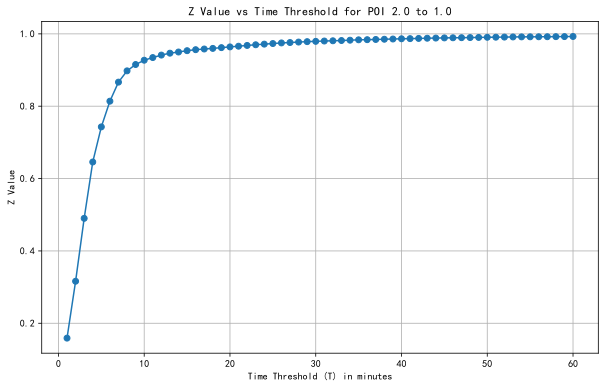

In [49]:
def Z(df, u, i, j, T):
    """ u 是出租车编号，i, j 是POI编号，T是时间阈值"""
    A = df[(df['出租车ID'] == u) & (df['起点（POI）'] == i) & (df['终点（POI）'] == j) & (df['耗时（分钟）'] < T)]
    B = df[(df['出租车ID'] == u) & (df['起点（POI）'] == i) & (df['终点（POI）'] == j)]
    if u == None:
        A = df[(df['起点（POI）'] == i) & (df['终点（POI）'] == j) & (df['耗时（分钟）'] < T)]
        B = df[(df['起点（POI）'] == i) & (df['终点（POI）'] == j)]
    return len(A) / len(B)

import matplotlib.pyplot as plt

# Define a range of T values
T_values = range(1, 61)  # From 1 to 60 minutes

# Calculate Z for each T value
Z_values = [Z(loaded_final_result, None, '2.0', '1.0', T) for T in T_values]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(T_values, Z_values, marker='o')
plt.xlabel('Time Threshold (T) in minutes')
plt.ylabel('Z Value')
plt.title('Z Value vs Time Threshold for POI 2.0 to 1.0')
plt.grid(True)

# Show the plot
plt.show()